In [1]:
import random as rand
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


In this notebook, we present a model for obtaining the location of a shrimp given 4 AUVs, and the time difference of arrivals of a snaps between each AUV. In this notebook, we simulate the location of a shrimp, "emit" a snap, record the location of arrivals. Then, we attempt to recover the location of the shrimp. Some results are printed. 

In our model, we use 4 AUVs and a shrimp, each with a (x,y) coordinate position. From this, we have to recover the shrimp (x,y). 

Geometrically, this makes sense. If an AUV hears a noise before another one does, the shrimp is closest to that AUV. Likewise, if we hear a noise after everyone else, the AUV is furthest from that AUV. 

In [2]:
#Gets the difference in position in terms of distance
def getDiffFromShrimp(shrimpPos, auvPos):
    diff = [[0,0],[0,0],[0,0],[0,0]]

    for i in range(len(auvPos)):
        diff[i] = [shrimpPos[0] - auvPos[i][0],shrimpPos[1] - auvPos[i][1]];
        
    return diff


In [3]:
#gets magnitude of position difference between each auv position, and shrimp, in terms of distance
def posdiffMagnitude(diff, error=0):
    mag = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    k = 0
    for i in range(4):
        for j in range(i+1, 4):
            mag[k] = (np.linalg.norm(diff[i])-np.linalg.norm(diff[j]))
            mag[k] = mag[k] + error;

            k = k+1
    return mag


The first function gets the distance between the shrimp and each AUV. The second gets the difference in lengths of arrivals from each of the 2 AUVs.

Now we create a setup. Each of the AUV's are 50 meters apart. Now, we setup our shrimpPosition 

In [31]:
auvPos = [[0,0],[0,0],[0,0],[0,0]]
pivotAuv = [20, 20];
auvPos[0] = pivotAuv;
auvPos[1] = [pivotAuv[0]+50, pivotAuv[1]];
auvPos[2] = [pivotAuv[0], pivotAuv[1]+50];
auvPos[3] = [pivotAuv[0]+50, pivotAuv[1]+50];
shrimpPos=[100,100]


posidiff = posdiffMagnitude(getDiffFromShrimp(shrimpPos, auvPos))

print(posidiff)

[18.362684616102193, 18.362684616102193, 56.568542494923804, 0.0, 38.205857878821611, 38.205857878821611]


Note that the 4th equation is 0. This makes sense because this is time difference of arrivals between 
AUVs 1 (70,20) and 2 (20, 70). The difference between these two points and (100,100) is 0. 

A loss function that the NLLS attempts to minimize. 

In [40]:
def loss(s):
    error = np.zeros(6)
    k = 0
    diff = getDiffFromShrimp(s, auvPos)
    for i in range(4):
        for j in range(i+1,4):
            #print(i,j)
            error[k] = posidiff[k]-(np.linalg.norm(diff[i])-np.linalg.norm(diff[j]))
            k = k+1
    return error

In [41]:
#Code to recover the center of the 4 AUV formation.
xsum = 0;
ysum = 0;
for i in range(4):
    xsum = auvPos[i][0] + xsum;
    ysum = auvPos[i][1] + ysum;

center = [0,0];
center[0] = xsum /4;
center[1] = ysum/ 4;

Now, we create an initial guess for our iterative solver. In this example, we show that as we move along the AUV formation, we can recover the initial position, except in one instance. This occurs because of precise symmetry in our model's coordinates. Along the top-left, bottom-right, we have perfect symmetry, and based on our initial guess, it recovers the "other" point. First, we color our guess with red. Then, we color our result with blue. If any red is leftover, we didn't recover that position. 

Adding some error, say 1e-2, the locations are recovered precisely.

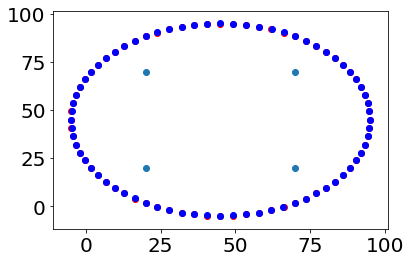

In [57]:
x,y = zip(*auvPos)

ang_range = np.arange(0,2*np.pi,2*np.pi/72);
#We have AUV positions..Now we evaluate accuracy based on distance
shrimp_orig = [center[0], center[1]];
plt.scatter(x,y);
for i in ang_range:
    shrimpPos = [shrimp_orig[0]+50*np.cos(i), shrimp_orig[1]+50*np.sin(i)];
    posidiff = posdiffMagnitude(getDiffFromShrimp(shrimpPos, auvPos), error=1e-2)
    res = least_squares(loss, initial)
    plt.scatter(shrimpPos[0], shrimpPos[1], color='r')
    plt.scatter(res.x[0], res.x[1], color='b')

plt.show();



Here we plot the error, if we add a bit of noise to our measurements of differences. Clearly, this result will be stellar.

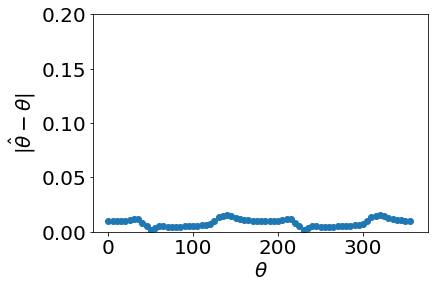

In [58]:
shrimp_orig = [center[0], center[1]];
#plt.scatter(x,y);
for i in ang_range:
    shrimpPos = [shrimp_orig[0]+50*np.cos(i), shrimp_orig[1]+50*np.sin(i)];
    posidiff = getDiffFromShrimp(shrimpPos, auvPos)
    posidiff = posdiffMagnitude(posidiff, error=1e-2)
    res = least_squares(loss, initial)
    result_angle = np.arctan2(res.x[1]-shrimp_orig[1], res.x[0]-shrimp_orig[0]) - np.arctan2(shrimpPos[1]-shrimp_orig[1], shrimpPos[0]-shrimp_orig[0]);
    plt.scatter(i * 360/(2*np.pi), abs(result_angle * 360/(2*np.pi)), color='C0')

plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.xlabel(r'$ \theta $');
plt.ylabel(r'$| \hat \theta - \theta |$')
plt.ylim(0,0.2);
plt.show();


We present code to graph the accuracy of our model as our distance increases.

How we do this: Move the known position distance (j) away. At each distance position, take the average of all the accuracies as we move around the center of the formation. 

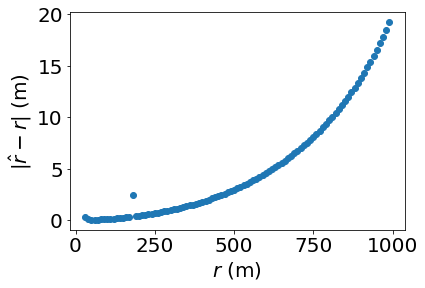

In [63]:
x,y = zip(*auvPos)
direct_range = np.arange(0, 1000, 10);
ang_range = np.arange(0,2*np.pi,2*np.pi/72);
#We have AUV positions..Now we evaluate accuracy based on distance
shrimp_orig = [center[0], center[1]];
#plt.scatter(x,y);
xvals = []
yvals = []
for j in direct_range:
    result_diff = 0;
    for i in ang_range:
        shrimpPos = [shrimp_orig[0]+j*np.cos(i), shrimp_orig[1]+j*np.sin(i)];
        posidiff = getDiffFromShrimp(shrimpPos, auvPos)
        posidiff = posdiffMagnitude(posidiff, error=1e-2)
        res = least_squares(loss, initial)
        #plt.plot([initial[0],res.x[0]], [initial[1],res.x[1]])
        #plt.plot([initial[0],shrimpPos[0]], [initial[1],shrimpPos[1]])
        result_diff = result_diff + np.linalg.norm(shrimpPos-res.x);
        #plt.scatter(res.x[0], res.x[1], color='b')    
    result_diff = result_diff/72.0;
    xvals.append(j)
    yvals.append(abs(result_diff))

plt.scatter(xvals[3:], yvals[3:]);
plt.xlabel("$r$ (m)");
plt.ylabel("$| \hat r - r |$ (m)");
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels

plt.show();

See that weird increase that near 180 meters? Lets look at it closer. When our angle is 225 degrees, we get a large error. That is because we do not converge to the right value at that point. 

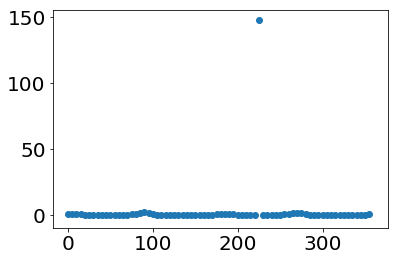

In [83]:
for i in ang_range:
    shrimpPos = [shrimp_orig[0]+180*np.cos(i), shrimp_orig[1]+180*np.sin(i)];
    posidiff = getDiffFromShrimp(shrimpPos, auvPos)
    posidiff = posdiffMagnitude(posidiff, error=1e-2)
    res = least_squares(loss, initial)
    result_diff = np.linalg.norm(shrimpPos-res.x);
    plt.scatter(i * 360/(2*np.pi), abs(result_diff), color='C0')

plt.show()



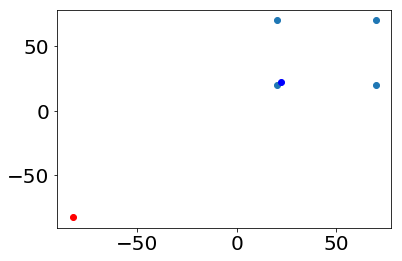

In [100]:
plt.scatter(x,y);

shrimpPos = [shrimp_orig[0]+180*np.cos(ang_range[45]), shrimp_orig[1]+180*np.sin(ang_range[45])];
posidiff = posdiffMagnitude(getDiffFromShrimp(shrimpPos, auvPos), error=1e-2)
res = least_squares(loss, initial)
plt.scatter(shrimpPos[0], shrimpPos[1], color='r')
plt.scatter(res.x[0], res.x[1], color='b')
plt.show();


Clearly, it appears related to the fact that we are too close to one of our points, combined with symmetry concerns.

We analyze the error in angle and distance as we increase our measurement accuracy.

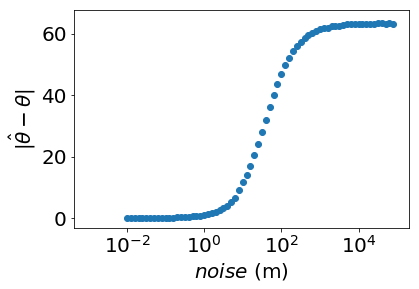

In [102]:

#We have AUV positions..Now we evaluate accuracy based on distance
shrimp_orig = [center[0], center[1]];
#plt.scatter(x,y);
for i in np.arange(-2,5,0.1):
    shrimpPos = [shrimp_orig[0]+50*np.cos(0), shrimp_orig[1]+50*np.sin(0)];
    posidiff = getDiffFromShrimp(shrimpPos, auvPos)
    posidiff = posdiffMagnitude(posidiff, error=10**i)
    res = least_squares(loss, initial)
    #plt.plot([initial[0],res.x[0]], [initial[1],res.x[1]])
    #plt.plot([initial[0],shrimpPos[0]], [initial[1],shrimpPos[1]])
    result_angle = np.arctan2(res.x[1]-shrimp_orig[1], res.x[0]-shrimp_orig[0]) - np.arctan2(shrimpPos[1]-shrimp_orig[1], shrimpPos[0]-shrimp_orig[0]);
    plt.scatter(10**i, abs(result_angle * 360/(2*np.pi)), color='C0')
    #plt.scatter(res.x[0], res.x[1], color='b')

plt.xscale('log')
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels

plt.xlabel(r'$ noise$ (m)');
plt.ylabel(r'$| \hat \theta - \theta |$')
plt.show();


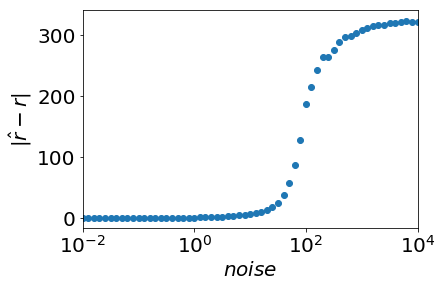

In [104]:
#We have AUV positions..Now we evaluate accuracy based on distance
shrimp_orig = [center[0], center[1]];
#plt.scatter(x,y);
xvals = []
yvals = []
for j in np.arange(-2,5,0.1):
    result_diff = 0;
    shrimpPos = [shrimp_orig[0]+75, shrimp_orig[1]+75];
    posidiff = getDiffFromShrimp(shrimpPos, auvPos)
    posidiff = posdiffMagnitude(posidiff, error=10**j)
    res = least_squares(loss, initial)
    #plt.plot([initial[0],res.x[0]], [initial[1],res.x[1]])
    #plt.plot([initial[0],shrimpPos[0]], [initial[1],shrimpPos[1]])
    result_diff = result_diff + np.linalg.norm(shrimpPos-res.x);
    #plt.scatter(res.x[0], res.x[1], color='b')    
    #result_diff = result_diff/72.0;
    xvals.append(10**j)
    yvals.append(abs(result_diff))

plt.scatter(xvals, yvals);
plt.xscale('log')
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.xlim(10**(-2),10**4)
plt.xlabel(r'$ noise $');
plt.ylabel(r'$| \hat r - r |$')
plt.show();


Conclusion: Our model does not work for accurately recovering the location once we reach about 2.5x the distance away the AUV's are from each other.